<a href="https://colab.research.google.com/github/GunjanDhanuka/potato-disease-classification/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Aug 29 18:59:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import models, layers

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/Projects/Potato Disease Classification/PlantVillage",
  shuffle=True,
  image_size = (IMAGE_SIZE, IMAGE_SIZE),
  batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 0 1 1 1 2 0 1 1 2 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0]


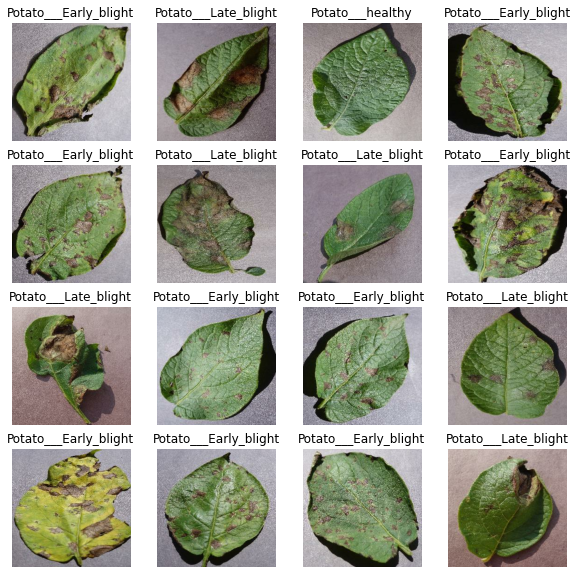

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(dataset)

68

In [ ]:
##80 percent train, 10 validation, 10 test
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
#dataset.skip skips the first 54 data entries(ie batches) and assigns from 55 to last
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def split_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if(shuffle):
    ds = ds.shuffle(shuffle_size, seed=19)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size * val_split)
  

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = split_dataset_tf(dataset)

In [ ]:
len(test_ds)

8

In [ ]:
 # "cache" Reads the image from the disk and for the next iteration keeps it in the memory
#Thus speeds up the iterations

#"prefetch" makes CPU loads the next batch of examples while the GPU is busy training on the current batch

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
#Image preprocessing

resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255),              
])

In [ ]:
#Data Augmentation using Tensorflow layers
data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Building the CNN Model
#TODO: Try to implement a popular architecture

image_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
                           resize_and_rescale,
                           data_augmentation,
                           layers.Conv2D(32, (3,3), activation='relu', input_shape= image_shape),
                           layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                        layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Flatten(),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = image_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 341s 133ms/step - loss: 0.8955 - accuracy: 0.4693 - val_loss: 0.7935 - val_accuracy: 0.6198
Epoch 2/50
54/54 [==============================] - 3s 59ms/step - loss: 0.6596 - accuracy: 0.7060 - val_loss: 0.4326 - val_accuracy: 0.8177
Epoch 3/50
54/54 [==============================] - 3s 58ms/step - loss: 0.4005 - accuracy: 0.8252 - val_loss: 0.3415 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2902 - accuracy: 0.8843 - val_loss: 0.3671 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 3s 57ms/step - loss: 0.2513 - accuracy: 0.9126 - val_loss: 0.3188 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 3s 58ms/step - loss: 0.2374 - accuracy: 0.9074 - val_loss: 0.1532 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 3s 58ms/step - loss: 0.1925 - accuracy: 0.9253 - val_loss: 0.1830 - val_accuracy: 0.9062
Epoch 8/50

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 84ms/step - loss: 0.0202 - accuracy: 0.9957


In [ ]:
history

In [ ]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

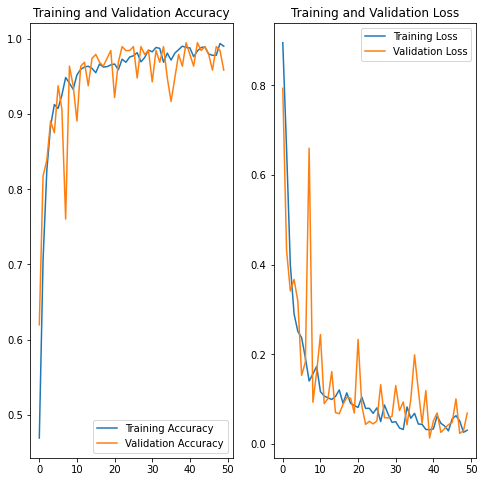

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np

image to predict
Actual Label:  Potato___Late_blight
Predicted Label:  Potato___Late_blight


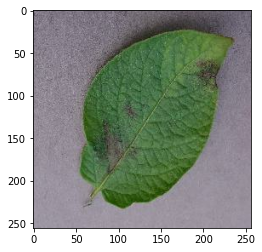

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("image to predict")
  plt.imshow(first_image)
  print("Actual Label: ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #Creates a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])), 2)

  return predicted_class, confidence

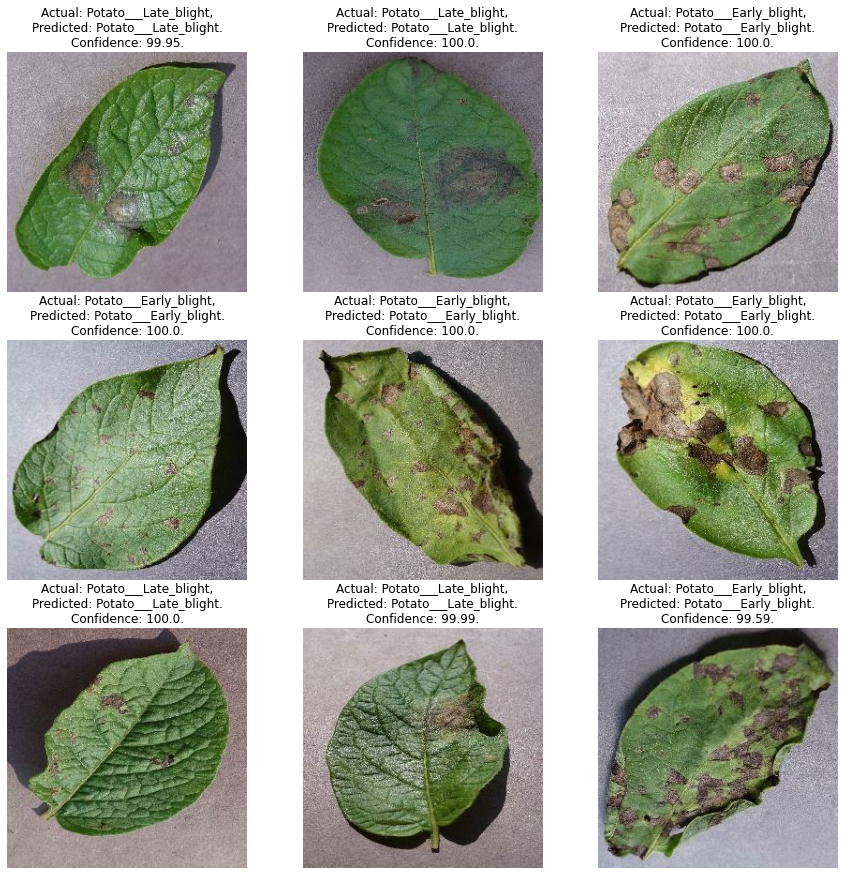

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}.")

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/Projects/Potato Disease Classification/models") + [0]])+1
model.save(f"/content/drive/MyDrive/Projects/Potato Disease Classification/models/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/Potato Disease Classification/models/2/assets
